<a href="https://colab.research.google.com/github/KurbanAbdulaev04/Overview_of_ML/blob/main/%D0%94_%D0%A0_%D0%90%D0%B1%D0%B4%D1%83%D0%BB%D0%B0%D0%B5%D0%B2_%D0%9A%D1%83%D1%80%D0%B1%D0%B0%D0%BD(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Реализация задачи классификации с использованием библиотеки PyTorch**

## Импорт необходимых модулей
Добавлена магическая команда **"%matplotlib inline"** для отображения графиков.

Импорт различных библиотек, необходимых для обработки данных, визуализации, машинного обучения и задач глубокого обучения.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

%matplotlib inline


## Загрузка данных

In [ ]:
data = pd.read_csv('/content/SBER_210101_250101.csv')
print(data.shape)
print(data.tail())

data.info()

(999, 7)
     <DATE>  <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>      <VOL>
994  241225       0  263.64  273.00  260.31   271.69  125501440
995  241226       0  272.02  274.25  269.10   269.56   75523970
996  241227       0  269.69  272.16  268.57   271.20   52121690
997  241228       0  271.37  273.99  270.40   272.83   39560080
998  241230       0  273.99  279.49  273.70   279.43   52353840
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   <DATE>   999 non-null    int64  
 1   <TIME>   999 non-null    int64  
 2   <OPEN>   999 non-null    float64
 3   <HIGH>   999 non-null    float64
 4   <LOW>    999 non-null    float64
 5   <CLOSE>  999 non-null    float64
 6   <VOL>    999 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 54.8 KB


## Предварительная обработка данных

* math.ceil: Используется для расчета количества точек обучающих данных (90% от общего объема данных).
* train_data и test_data: Разделите фрейм данных на обучающий и тестовый наборы.
* MinMaxScaler: Масштабирует данные в диапазоне [0, 1]. Такая нормализация помогает нейронной сети быстрее сходиться.

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler

# разделение на тестовые данные
training_data_len = math.ceil(len(data) * .9)
print(training_data_len)

# разделение набора данных на обучающие и тестовые
train_data = data[:training_data_len].iloc[:, 5:6]
test_data = data[training_data_len:].iloc[:, 5:6]
print(train_data.shape, test_data.shape)

# выбор значений цены закрытия
dataset_train = train_data.values
dataset_test = test_data.values
# преобразование 1D-массива в 2D-массив
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# масштабирование набора данных
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Нормализация значений от 0 до 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])


900
(900, 1) (99, 1)
(900, 1)
(99, 1)
[[0.59594547]
 [0.60713037]
 [0.59919609]
 [0.63663055]
 [0.65707794]]
[[0.97476453]
 [0.91416385]
 [0.79989337]
 [0.7648836 ]
 [0.77785676]]


## Создадим последовательности и метки для обучения и тестирования

Структурируем данные в последовательности для модели LSTM. Каждая последовательность содержит заданное количество временных шагов. Затем преобразуем данные в тензоры PyTorch, которые необходимы для ввода в модель PyTorch.

* sequence_length: Количество временных шагов, на которые модель оглядывается назад, чтобы сделать прогноз.
* X_train и y_train: Массивы для хранения входных последовательностей и соответствующих им меток для обучения.
* X_test и y_test: Массивы для тестирования данных.
* torch.tensor: Преобразует массивы numpy в тензоры PyTorch.

In [ ]:
# Создание последовательностей и меток для обучающих данных
sequence_length = 50  # количество временных шагов, на которые нужно оглянуться назад
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # прогнозирование значения сразу после выполнения последовательности
X_train, y_train = np.array(X_train), np.array(y_train)

# преобразование данных в тензоры PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Создание последовательностей и меток для тестирования данных
sequence_length = 30  # количество временных шагов, на которые нужно оглянуться назад
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Прогнозирование значения сразу после выполнения последовательности
X_test, y_test = np.array(X_test), np.array(y_test)

# преобразование данных в тензоры PyTorch
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([850, 50, 1]) torch.Size([850, 1])
torch.Size([69, 30, 1]) torch.Size([69, 1])


## Определение и обучение модели LSTM

Определение модели LSTM для прогнозирования временных рядов. Модель включает уровень LSTM, за которым следует полностью связанный уровень.

* LSTMModel: Класс нейронной сети PyTorch со слоем LSTM и линейным слоем.
* Конфигурация устройства(Device Configuration): Проверьте, доступен ли графический процессор, и используйте его, если это возможно.
* Гиперпараметры: Такие настройки, как размер ввода, скрытый размер, количество слоев, частота отсева, размер пакета, скорость обучения и количество эпох.
* Загрузчик данных(DataLoader): Утилита для пакетной обработки и перетасовки набора данных.
* Цикл обучения(Training Loop): Цикл по набору данных за указанное количество эпох, выполнение прямых и обратных проходов и обновление весов модели.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # количество слоев
hidden_size = 128  # количество скрытых юнитов
output_size = 1
dropout = 0.2  # отсев для упорядочения, помогает предотвратить переобучение

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # оптимизация скоромсти обучения

batch_size = 32  # скорректированный размер партии
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # количество эпох
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


cpu
Epoch [10/100] - Training Loss: 0.0023, Test Loss: 0.0930
Epoch [20/100] - Training Loss: 0.0017, Test Loss: 0.0507
Epoch [30/100] - Training Loss: 0.0013, Test Loss: 0.0291
Epoch [40/100] - Training Loss: 0.0010, Test Loss: 0.0188
Epoch [50/100] - Training Loss: 0.0010, Test Loss: 0.0151
Epoch [60/100] - Training Loss: 0.0009, Test Loss: 0.0140
Epoch [70/100] - Training Loss: 0.0008, Test Loss: 0.0124
Epoch [80/100] - Training Loss: 0.0007, Test Loss: 0.0119
Epoch [90/100] - Training Loss: 0.0006, Test Loss: 0.0111
Epoch [100/100] - Training Loss: 0.0007, Test Loss: 0.0106


## Визуализация модели

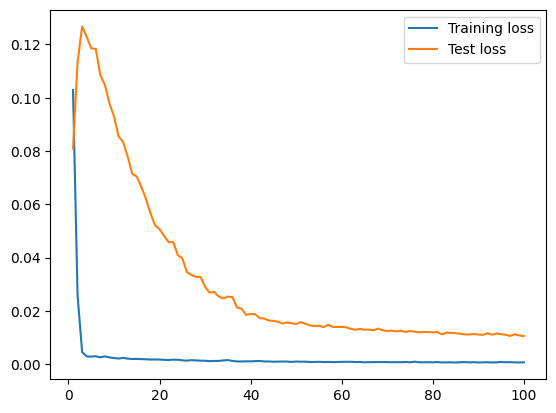

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


Точность тестовых данных, как видим на графике, нихкая.

Для получения более точных прогнозов часто требуются дополнительные корректировки, настройка гиперпараметров и оптимизация. Для улучшения возможностей прогнозирования можно использовать методы ансамблей(ensemble) и другие передовые методологии.

